In [41]:
#Imports
import pandas as pd

#Dataset 1 loading
file_path = "/kaggle/input/nasa-exoplanet/nasa_exoplanet.csv"

#loading into a dataframe
df=pd.read_csv(file_path,comment='#',engine="python",on_bad_lines="skip")
df.isnull().sum()



pl_name              0
hostname             0
default_flag         0
sy_snum              0
sy_pnum              0
                  ... 
sy_gaiamagerr1    1136
sy_gaiamagerr2    1136
rowupdate           36
pl_pubdate          35
releasedate         35
Length: 92, dtype: int64

In [42]:
needed = [
    "pl_rade", "pl_bmasse", "pl_dens", "pl_eqt",
    "pl_orbper", "sy_dist", "st_teff", 
    "st_lum", "st_spectype", "st_metfe",
    "pl_orbeccen", "pl_orbsmax"
]
df = df[[col for col in needed if col in df.columns]]

df = df.rename(columns={
    "pl_rade": "radius",
    "pl_bmasse": "mass",
    "pl_eqt": "temp",
    "pl_orbper": "orbital_period",
    "sy_dist": "distance_star",
    "st_teff": "star_temp",
    "st_spectype": "star_type",
    "pl_orbeccen": "eccentricity",
    "pl_orbsmax": "semi_major_axis"
})
df.isnull().sum()



radius             12169
mass               32101
temp               22007
orbital_period      3311
distance_star        879
star_temp           3486
star_type          36290
eccentricity       20455
semi_major_axis    17238
dtype: int64

In [43]:
selected_cols = [
    "radius", "mass", "temp", "orbital_period",
    "distance_star", "star_temp", "star_type",
    "eccentricity", "semi_major_axis"
]
df=df[selected_cols]


In [44]:
file2_path="/kaggle/input/exoplanetsdata1/exoplanetsdata1.csv"
df2 = pd.read_csv(file2_path, comment='#', engine="python", on_bad_lines="skip")
df2 = df2.loc[:, ~df2.columns.str.contains("^Unnamed")]
df2.isnull().sum()



#Removes all columns whose name starts with "Unnamed" (those are usually junk index columns in CSVs).

#df2.columns.str.contains("^Unnamed") → boolean mask for which columns are “Unnamed…”

#~ negates the mask.

#df2.loc[:, mask] → selects all rows (:) and only columns where mask is True.

pl_name              0
hostname             0
sy_snum              0
sy_pnum              0
discoverymethod      0
                  ... 
sy_kmagerr1        241
sy_kmagerr2        253
sy_gaiamag         259
sy_gaiamagerr1     261
sy_gaiamagerr2     261
Length: 85, dtype: int64

In [45]:
df2 = df2.rename(columns={
    "pl_rade": "radius",
    "pl_bmasse": "mass",
    "pl_eqt": "temp",
    "pl_orbper": "orbital_period",
    "sy_dist": "distance_star",
    "st_teff": "star_temp",
    "st_spectype": "star_type",
    "pl_orbeccen": "eccentricity",
    "pl_orbsmax": "semi_major_axis"
})
df2=df2[selected_cols]

In [46]:
combined_df=pd.concat([df,df2],ignore_index=True)

combined_df=combined_df.drop_duplicates()
combined_df["star_type"]=combined_df["star_type"].fillna("Unknown")


In [47]:
numeric_cols = [
    "radius",
    "mass",
    "temp",
    "orbital_period",
    "distance_star",
    "star_temp",
    "eccentricity",
    "semi_major_axis"
]

for col in numeric_cols:
    combined_df[col] = pd.to_numeric(combined_df[col], errors="coerce")
#converts all values to numeric,if not possible coerces to convert to "NaN"

In [48]:
combined_df = combined_df[
    combined_df["eccentricity"].isna() |
    combined_df["eccentricity"].between(0, 1)
]

combined_df = combined_df[
    combined_df["radius"].isna() |
    (combined_df["radius"] > 0)
]

combined_df = combined_df[
    combined_df["mass"].isna() |
    (combined_df["mass"] > 0)
]

combined_df = combined_df[
    combined_df["orbital_period"].isna() |
    (combined_df["orbital_period"] > 0)
]


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [49]:
combined_df.isnull().sum()

radius             12017
mass               26666
temp               23247
orbital_period      3395
distance_star        686
star_temp           3548
star_type              0
eccentricity       21004
semi_major_axis    17438
dtype: int64

In [50]:
df_clean = combined_df.copy()


In [51]:
for col in selected_cols:
    print(df_clean[col].describe())

"""""
## 🔍 Outlier Detection Using Summary Statistics
### What we check:
- Minimum and maximum values  
- Median and quartiles  
- Domain validity (e.g., eccentricity must be 0–1, radius must be < 30 Earth radii)

"""

count    26806.000000
mean         5.180188
std         52.023655
min          0.270000
25%          1.610000
50%          2.410000
75%          3.890000
max       4282.980000
Name: radius, dtype: float64
count     12157.000000
mean        638.869830
std        2938.866326
min           0.015000
25%           6.356600
50%          47.672500
75%         483.101600
max      239000.000000
Name: mass, dtype: float64
count    15576.000000
mean       904.460688
std        450.970748
min         34.000000
25%        574.000000
50%        812.000000
75%       1145.000000
max       4050.000000
Name: temp, dtype: float64
count    3.542800e+04
mean     2.440642e+04
std      3.021971e+06
min      9.070629e-02
25%      4.333787e+00
50%      1.035853e+01
75%      2.855139e+01
max      4.020000e+08
Name: orbital_period, dtype: float64
count    38137.000000
mean       704.571136
std        876.223917
min          1.301190
25%        232.964000
50%        531.944000
75%        905.937000
max       8980

'""\n## 🔍 Outlier Detection Using Summary Statistics\n### What we check:\n- Minimum and maximum values  \n- Median and quartiles  \n- Domain validity (e.g., eccentricity must be 0–1, radius must be < 30 Earth radii)\n\n'

In [52]:
df_clean.shape

(38823, 9)

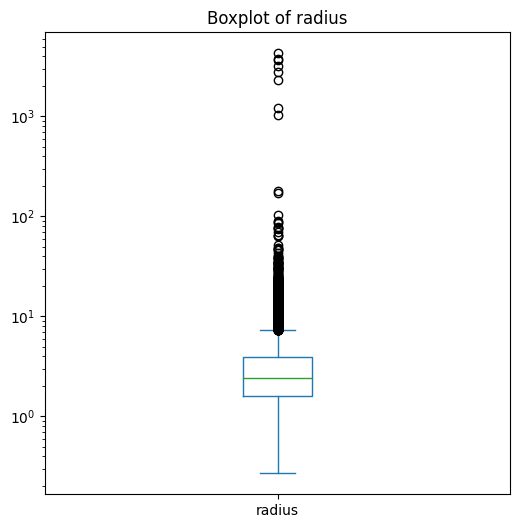

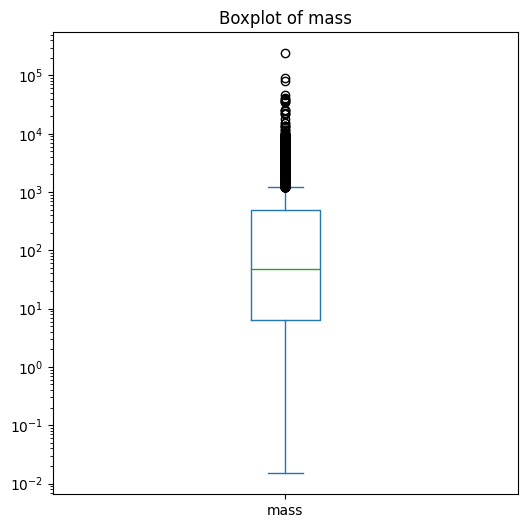

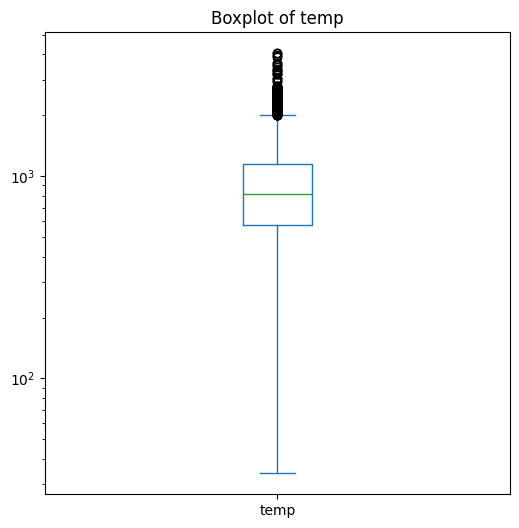

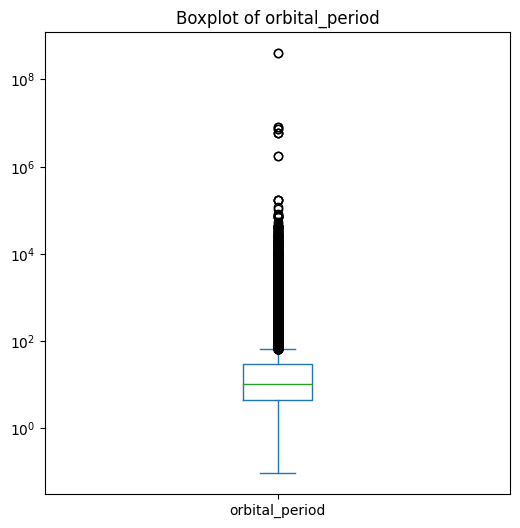

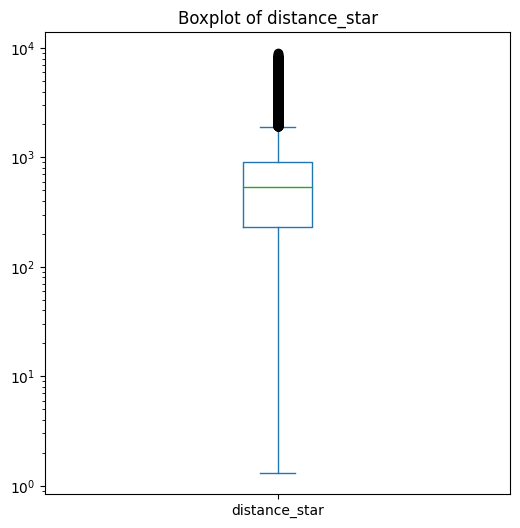

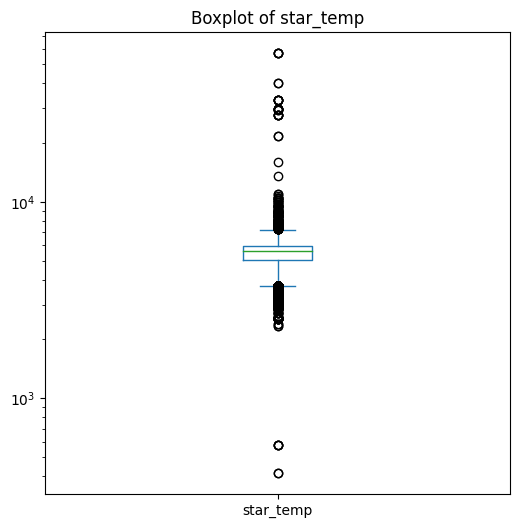

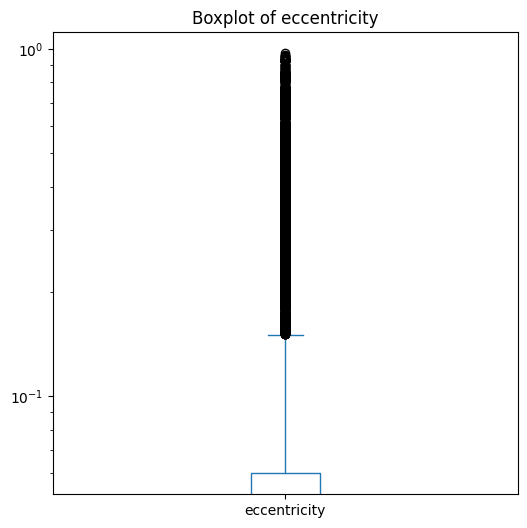

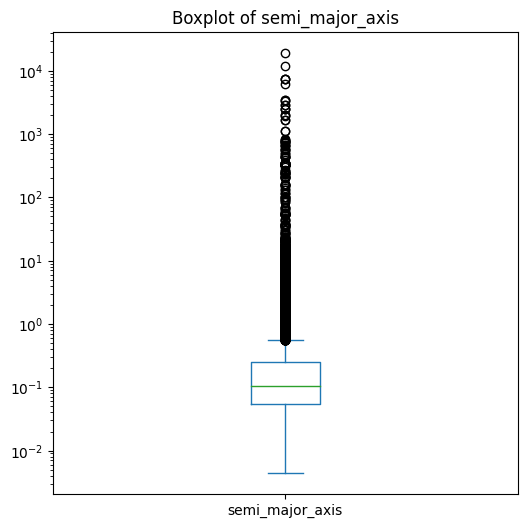

In [53]:
import matplotlib.pyplot as plt

numeric_cols = [
    "radius", "mass", "temp", "orbital_period",
    "distance_star", "star_temp", "eccentricity",
    "semi_major_axis"
]

for col in numeric_cols:
    plt.figure(figsize=(6,6))
    df_clean[col].dropna().plot(kind="box", vert=True)
    plt.yscale('log')
    plt.title(f"Boxplot of {col}")
    plt.show()

In [54]:
#One hot Encoding
print("Before encoding:",df_clean.shape)
df_encoded=pd.get_dummies(df_clean,columns=['star_type'],prefix='star')
print("after encoding:",df_encoded.shape)
df_encoded.head()
df_encoded = df_encoded.loc[:, (df_encoded != 0).any(axis=0)] #columns with one non - zero value ar ekept..all zero columns are removed
print("Shape after cleanup:", df_encoded.shape)


Before encoding: (38823, 9)
after encoding: (38823, 347)
Shape after cleanup: (38823, 347)


In [55]:
# ---------------------------------------------------
# Feature Engineering Example: Habitability Score Index
# (Analysis-only, NOT used as ML label)
# ---------------------------------------------------

df_hab = df_clean.copy()

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Individual component scores (Earth-like references)
radius_score = 1 - normalize(abs(df_hab["radius"] - 1.0))        # Earth radius ≈ 1
temp_score   = 1 - normalize(abs(df_hab["temp"] - 288))          # Earth temp ≈ 288 K
orbit_score  = 1 - normalize(abs(df_hab["orbital_period"] - 365))# Earth year ≈ 365 days
ecc_score    = 1 - normalize(df_hab["eccentricity"])             # Low eccentricity preferred

# Weighted habitability score
df_hab["habitability_score"] = (
      0.35 * radius_score
    + 0.35 * temp_score
    + 0.20 * orbit_score
    + 0.10 * ecc_score
)

# Ensure score lies between 0 and 1
df_hab["habitability_score"] = df_hab["habitability_score"].clip(0, 1)

# Preview
df_hab[["radius", "temp", "eccentricity", "habitability_score"]].head()


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,radius,temp,eccentricity,habitability_score
0,NaN,NaN,0.238,NaN
1,NaN,NaN,0.231,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,0.080,NaN
4,NaN,NaN,0.080,NaN


In [56]:
# ---------------------------------------------------
# Feature Engineering Example 2: Stellar Compatibility Index
# (Analysis-only, NOT used as ML label)
# ---------------------------------------------------

df_sci = df_clean.copy()

def safe_normalize(series):
    if series.max() == series.min():
        return pd.Series([0.5] * len(series)) #creates a new series where each value is 0.5(neutral point)
    return (series - series.min()) / (series.max() - series.min())

# 1️⃣ Stellar temperature suitability (Sun ≈ 5778 K)
df_sci["star_temp_score"] = 1 - safe_normalize(
    abs(df_sci["star_temp"] - 5778)
)

# 2️⃣ Spectral type compatibility (domain knowledge)
spectral_weights = {
    "O": 0.1,
    "B": 0.2,
    "A": 0.3,
    "F": 0.6,
    "G": 1.0,
    "K": 0.8,
    "M": 0.6,
    "Unknown": 0.5
}

df_sci["spectral_score"] = df_sci["star_type"].map(spectral_weights)

# If any star_type was unseen
df_sci["spectral_score"] = df_sci["spectral_score"].fillna(0.5)

# 3️⃣ Final Stellar Compatibility Index
df_sci["stellar_compatibility_index"] = (
      0.6 * df_sci["star_temp_score"]
    + 0.4 * df_sci["spectral_score"]
)

# Ensure valid range
df_sci["stellar_compatibility_index"] = df_sci[
    "stellar_compatibility_index"
].clip(0, 1)

# Preview
df_sci[
    ["star_temp", "star_type", "stellar_compatibility_index"]
].head()


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,star_temp,star_type,stellar_compatibility_index
0,4874.0,G8 III,0.789411
1,4742.0,G8 III,0.787865
2,NaN,Unknown,NaN
3,4340.0,K4 III,0.783156
4,4213.0,Unknown,0.781668


In [57]:
df_cls = df_clean.copy()
df_cls["habitable_class"] = (
    (df_cls["radius"].between(0.5, 2.0)) &
    (df_cls["temp"].between(180, 320)) &
    (df_cls["eccentricity"] < 0.3)
).astype(int)

print(df_cls["habitable_class"].value_counts())
print(df_cls["habitable_class"].value_counts(normalize=True) * 100)


habitable_class
0    38690
1      133
Name: count, dtype: int64
habitable_class
0    99.65742
1     0.34258
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [58]:
features = [
    "radius",
    "mass",
    "temp",
    "orbital_period",
    "distance_star",
    "star_temp",
    "eccentricity",
    "semi_major_axis",
    "star_type"
] #independent features

X = df_cls[features]
y = df_cls["habitable_class"] #depended features
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y, #stratify --ensures train and test splits have same class distribution
    random_state=42,
    )

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (38823, 9)
y shape: (38823,)


In [59]:


print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (31058, 9)
X_test: (7765, 9)
y_train: (31058,)
y_test: (7765,)


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

#It prepares raw data so that a machine-learning model can safely and correctly learn from it.
#MinMaxScaler → scale numbers to 0–1

#OneHotEncoder → convert text → numbers
numeric_features = [
    "radius",
    "mass",
    "temp",
    "orbital_period",
    "distance_star",
    "star_temp",
    "eccentricity",
    "semi_major_axis"
]

categorical_features = ["star_type"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([ #ColumnTransformer → apply different steps to different columns
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])
###Applies:
#numeric_pipeline → numeric columns

#categorical_pipeline → categorical columns

#Then combines the results into one matrix 

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_model)
])


In [62]:
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['radius', 'mass', 'temp',
                                                   'orbital_period',
                                                   'distance_star', 'star_temp',
                                                   'eccentricity',
                                                   'semi_major_axis']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['star_type'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [63]:
import pandas as pd
import numpy as np

feature_names=rf_pipeline.named_steps["preprocessor"].get_feature_names_out()

importances=rf_pipeline.named_steps["model"].feature_importances_

importance_df=pd.DataFrame({
    "feature":feature_names,
    "importance":importances
}).sort_values(by="importance",ascending=False)
importance_df.head(15)

,feature,importance
2,num__temp,0.361260
0,num__radius,0.220230
5,num__star_temp,0.162939
4,num__distance_star,0.080265
7,num__semi_major_axis,0.080034
1,num__mass,0.047577
6,num__eccentricity,0.016226
3,num__orbital_period,0.007615
333,cat__star_type_Unknown,0.003073
307,cat__star_type_M4.5 V,0.002718


In [64]:
y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]
threshold=0.3
y_pred_custom=(y_proba>=threshold).astype(int)
pd.Series(y_proba).describe()


count    7765.000000
mean        0.010902
std         0.051473
min         0.000000
25%         0.003379
50%         0.003379
75%         0.007765
max         0.941706
dtype: float64

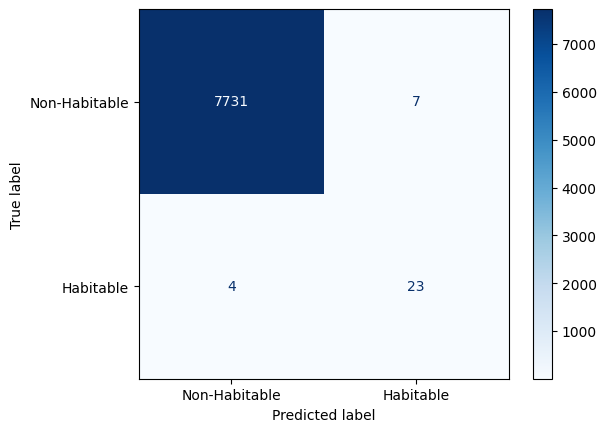

In [65]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Non-Habitable","Habitable"])
disp.plot(cmap="Blues")

In [66]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

accuracy = accuracy_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom, zero_division=0)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)
roc_auc = roc_auc_score(y_test, y_proba)
print("Random Forest")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("ROC-AUC  :", roc_auc)


Random Forest
Accuracy : 0.9981970379909851
Precision: 0.6857142857142857
Recall   : 0.8888888888888888
F1-score : 0.7741935483870968
ROC-AUC  : 0.999487856944564


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
logreg_model=LogisticRegression(max_iter=1000,class_weight="balanced",random_state=42)
logreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", logreg_model)
])
logreg_pipeline.fit(X_train, y_train)
# ---------------------------------------------------

y_proba_lr = logreg_pipeline.predict_proba(X_test)[:, 1]
threshold=0.3
y_pred_lr=(y_proba_lr>=threshold).astype(int)
print("Logistic Regression Metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1-score :", f1_score(y_test, y_pred_lr))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_lr))

Logistic Regression Metrics
Accuracy : 0.9304571796522859
Precision: 0.047619047619047616
Recall   : 1.0
F1-score : 0.0909090909090909
ROC-AUC  : 0.9948498511434671


In [68]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
svm_model=SVC(kernel="rbf",class_weight="balanced",probability=True,random_state=42)

svm_pipeline=Pipeline([ ("preprocessor", preprocessor),
    ("model", svm_model)
])
svm_pipeline.fit(X_train, y_train)

# Predict


y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]
threshold=0.3
y_pred_svm = (y_proba_svm>=threshold).astype(int)

# Evaluate
print("SVM Metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_svm))
print("F1-score :", f1_score(y_test, y_pred_svm))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_svm))

SVM Metrics
Accuracy : 0.9949774629748873
Precision: 0.16666666666666666
Recall   : 0.1111111111111111
F1-score : 0.13333333333333333
ROC-AUC  : 0.9957114002086864


In [69]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


In [70]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])
xgb_pipeline.fit(X_train, y_train)

y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
threshold=0.3
y_pred_xgb=(y_proba_xgb>=threshold).astype(int)
print("XGBoost Metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1-score :", f1_score(y_test, y_pred_xgb))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_xgb))


XGBoost Metrics
Accuracy : 0.998454603992273
Precision: 0.7142857142857143
Recall   : 0.9259259259259259
F1-score : 0.8064516129032259
ROC-AUC  : 0.9878090807271473


In [71]:
df_ranking = df_cls.copy()

df_ranking["predicted_habitability_probability"] = (
    rf_pipeline.predict_proba(df_cls[features])[:, 1]
)
df_ranking = df_ranking.sort_values(
    by="predicted_habitability_probability",
    ascending=False
)
df_ranking[
    [
        "radius",
        "temp",
        "eccentricity",
        "star_type",
        "predicted_habitability_probability"
    ]
].head(10)


,radius,temp,eccentricity,star_type,predicted_habitability_probability
17631,1.820,310.0,0.000,Unknown,0.989479
23171,1.060,248.0,0.000,Unknown,0.982281
12802,1.390,244.0,0.000,Unknown,0.982047
12803,1.560,251.0,0.000,Unknown,0.981508
23174,1.080,244.0,0.000,Unknown,0.977668
12808,1.410,264.0,0.000,Unknown,0.977081
27205,1.610,229.0,0.000,Unknown,0.975518
23191,1.610,241.0,0.000,Unknown,0.971787
37445,1.045,219.0,0.063,Unknown,0.968758
23182,1.230,199.0,0.000,Unknown,0.967685


In [72]:
y.value_counts(), y.value_counts(normalize=True) * 100


(habitable_class
 0    38690
 1      133
 Name: count, dtype: int64,
 habitable_class
 0    99.65742
 1     0.34258
 Name: proportion, dtype: float64)

In [73]:
import joblib
joblib.dump(xgb_pipeline,"/kaggle/working/habitability_trained.pkl")


['/kaggle/working/habitability_trained.pkl']

In [74]:
import os
os.listdir("/kaggle/working")

['.virtual_documents', 'habitability_trained.pkl']